<img src="../images/cmip6-cookbook-thumbnail.png" width=250 alt="CMIP6 image"></img>

# Regridding with xESMF and calculating a multi-model mean

---

## Overview

The main goal of this workflow is to calculate the mean change in ocean heat uptake (OHU) associated with the transient climate response (TCR) for CMIP6. TCR is defined as the change in global mean surface temperature at the time of CO$_2$ doubling in a climate model run with a 1% increase in CO$_2$ per year. The amount and pattern of heat uptake into the oceans are important in determining the strength of radiative feedbacks and thus climate sensitivity. See [Xie (2020)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019AV000130) for an overview.

In order to use as many models as possible, we will need to load the model output in its native grid, then regrid to a common grid (here 1°x1° lat-lon) using [xESMF](https://xesmf.readthedocs.io/en/latest/). From there, we can take the average across models and either plot the result or save it as a netCDF file for later use.

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Necessary | |
| [Computations and Masks with Xarray](https://foundations.projectpythia.org/core/xarray/computation-masking.html) | Necessary | |
| [Load CMIP6 Data with Intake-ESM](https://projectpythia.org/cmip6-cookbook/notebooks/foundations/intake-esm.html) | Necessary | |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Helpful | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | |
| Familiarity with CMIP6 | Helpful | |

- **Time to learn**: 30 minutes

---

## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import xarray as xr
import intake
import xesmf as xe
from cartopy import crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

## Access the data

First, we will open and search the Pangeo CMIP6 catalog for monthly `hfds` (downward heat flux at the sea surface) for the control (`piControl`) and 1%/year CO$_2$ (`1pctCO2`) runs for all available models on their native grids. The argument `require_all_on='source_id'` ensures that each model used has both experiments required for this analysis.

In [2]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

In [3]:
query = dict(experiment_id=['1pctCO2', 'piControl'], table_id='Omon', variable_id='hfds', 
             grid_label='gn', member_id='r1i1p1f1', require_all_on='source_id')

cat = col.search(**query)
cat.df

/srv/conda/envs/notebook/lib/python3.10/site-packages/intake_esm/_search.py:80: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, group in grouped:


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CSIRO-ARCCSS,ACCESS-CM2,1pctCO2,r1i1p1f1,Omon,hfds,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191109
1,CMIP,CSIRO-ARCCSS,ACCESS-CM2,piControl,r1i1p1f1,Omon,hfds,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191112
2,CMIP,CSIRO,ACCESS-ESM1-5,1pctCO2,r1i1p1f1,Omon,hfds,gn,gs://cmip6/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/1pct...,NaN,20191115
3,CMIP,CSIRO,ACCESS-ESM1-5,piControl,r1i1p1f1,Omon,hfds,gn,gs://cmip6/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piCo...,NaN,20191214
4,CMIP,AWI,AWI-CM-1-1-MR,1pctCO2,r1i1p1f1,Omon,hfds,gn,gs://cmip6/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/1pctCO...,NaN,20181218
5,CMIP,AWI,AWI-CM-1-1-MR,piControl,r1i1p1f1,Omon,hfds,gn,gs://cmip6/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/piCont...,NaN,20181218
6,CMIP,CAMS,CAMS-CSM1-0,1pctCO2,r1i1p1f1,Omon,hfds,gn,gs://cmip6/CMIP6/CMIP/CAMS/CAMS-CSM1-0/1pctCO2...,NaN,20190708
7,CMIP,CAMS,CAMS-CSM1-0,piControl,r1i1p1f1,Omon,hfds,gn,gs://cmip6/CMIP6/CMIP/CAMS/CAMS-CSM1-0/piContr...,NaN,20190729
8,CMIP,NCAR,CESM2,piControl,r1i1p1f1,Omon,hfds,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/piControl/r1i...,NaN,20190320
9,CMIP,NCAR,CESM2,1pctCO2,r1i1p1f1,Omon,hfds,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/1pctCO2/r1i1p...,NaN,20190425


Conveniently, NCAR contributed some data to CMIP6 that has already been regridded to a 1x1 lat-lon grid, which is the resolution I am interested in for the ensemble mean. We will use the coordinates from this Dataset when we create the xESMF regridder.

In [4]:
rg_query = dict(source_id='CESM2', experiment_id='piControl', table_id='Omon', variable_id='hfds', 
             grid_label='gr', member_id='r1i1p1f1', require_all_on=['source_id'])

rg_cat = col.search(**rg_query)
rg_cat.df

/srv/conda/envs/notebook/lib/python3.10/site-packages/intake_esm/_search.py:80: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, group in grouped:


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,piControl,r1i1p1f1,Omon,hfds,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/piControl/r1i...,NaN,20190320


Now, make the dictionaries with the data:

In [5]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})
list(dset_dict.keys())

/tmp/ipykernel_238/4245233592.py:1: DeprecationWarning: cdf_kwargs and zarr_kwargs are deprecated and will be removed in a future version. Please use xarray_open_kwargs instead.
  dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


['CMIP.AWI.AWI-CM-1-1-MR.1pctCO2.Omon.gn',
 'CMIP.CAMS.CAMS-CSM1-0.1pctCO2.Omon.gn',
 'CMIP.NCAR.CESM2.1pctCO2.Omon.gn',
 'CMIP.MPI-M.MPI-ESM1-2-LR.1pctCO2.Omon.gn',
 'CMIP.CAS.FGOALS-g3.1pctCO2.Omon.gn',
 'CMIP.NASA-GISS.GISS-E2-1-G.piControl.Omon.gn',
 'CMIP.CMCC.CMCC-CM2-SR5.piControl.Omon.gn',
 'CMIP.NCAR.CESM2-WACCM-FV2.piControl.Omon.gn',
 'CMIP.IPSL.IPSL-CM6A-LR.piControl.Omon.gn',
 'CMIP.NASA-GISS.GISS-E2-1-H.1pctCO2.Omon.gn',
 'CMIP.SNU.SAM0-UNICON.1pctCO2.Omon.gn',
 'CMIP.CSIRO.ACCESS-ESM1-5.piControl.Omon.gn',
 'CMIP.NCAR.CESM2-FV2.1pctCO2.Omon.gn',
 'CMIP.NASA-GISS.GISS-E2-2-G.piControl.Omon.gn',
 'CMIP.UA.MCM-UA-1-0.piControl.Omon.gn',
 'CMIP.UA.MCM-UA-1-0.1pctCO2.Omon.gn',
 'CMIP.MPI-M.MPI-ESM1-2-LR.piControl.Omon.gn',
 'CMIP.MPI-M.MPI-ESM1-2-HR.1pctCO2.Omon.gn',
 'CMIP.CMCC.CMCC-ESM2.piControl.Omon.gn',
 'CMIP.IPSL.IPSL-CM6A-LR.1pctCO2.Omon.gn',
 'CMIP.NCAR.CESM2.piControl.Omon.gn',
 'CMIP.NASA-GISS.GISS-E2-1-G.1pctCO2.Omon.gn',
 'CMIP.NCAR.CESM2-WACCM.1pctCO2.Omon.gn',


In [6]:
rg_dset_dict = rg_cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})
list(rg_dset_dict.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/tmp/ipykernel_238/2341675588.py:1: DeprecationWarning: cdf_kwargs and zarr_kwargs are deprecated and will be removed in a future version. Please use xarray_open_kwargs instead.
  rg_dset_dict = rg_cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


['CMIP.NCAR.CESM2.piControl.Omon.gr']

## Define some functions and organize

First, let's make a function to get the diagnostic of interest: the change in ocean heat uptake at the time of transient CO$_2$ doubling compared to the pre-industrial control:

In [7]:
def get_tcr(ctrl_key, expr_key):
    ds_1pct = dset_dict[expr_key].squeeze()
    ds_piCl = dset_dict[ctrl_key].squeeze()
    ds_tcr = ds_1pct.isel(time=slice(12*59, 12*80)).mean(dim='time') - ds_piCl.isel(time=slice(12*59, 12*80)).mean(dim='time')
    return ds_tcr

Note that the time slice is 20 years centered around year 70, which is when CO$_2$ doubles in a 1pctCO2 experiment ($1.01^{70}\approx 2$). Just for convenience, we will also define a function that creates the xESMF regridder and performs the regridding. The regridder is specific to the input (`ds_in`) and output (`regrid_to`) grids, so it must be redefined for each model. 

In [8]:
def regrid(ds_in, regrid_to, method='bilinear'):
    regridder = xe.Regridder(ds_in, regrid_to, method=method, periodic=True, ignore_degenerate=True)
    ds_out = regridder(ds_in)
    return ds_out

Finally, the following function takes the list of keys generated by Intake-ESM and splits them into two sorted lists of keys: one for the piControl experiment and another for 1pctCO2. This will work nicely with the `get_tcr()` function.

In [9]:
def sorted_split_list(a_list):
    c_list = []
    e_list = []
    for item in a_list:
        if 'piControl' in item:
            c_list.append(item)
        elif '1pctCO2' in item:
            e_list.append(item)
        else: print('Could not find experiment name in key:'+item)
    return sorted(c_list), sorted(e_list)

Let's make the lists and look at them to make sure they are properly sorted:

In [10]:
ctrl_keys, expr_keys = sorted_split_list(list(dset_dict.keys()))

In [11]:
for i in range(len(ctrl_keys)):
    print(ctrl_keys[i]+'\t\t'+expr_keys[i])

CMIP.AS-RCEC.TaiESM1.piControl.Omon.gn		CMIP.AS-RCEC.TaiESM1.1pctCO2.Omon.gn
CMIP.AWI.AWI-CM-1-1-MR.piControl.Omon.gn		CMIP.AWI.AWI-CM-1-1-MR.1pctCO2.Omon.gn
CMIP.CAMS.CAMS-CSM1-0.piControl.Omon.gn		CMIP.CAMS.CAMS-CSM1-0.1pctCO2.Omon.gn
CMIP.CAS.FGOALS-g3.piControl.Omon.gn		CMIP.CAS.FGOALS-g3.1pctCO2.Omon.gn
CMIP.CCCma.CanESM5.piControl.Omon.gn		CMIP.CCCma.CanESM5.1pctCO2.Omon.gn
CMIP.CMCC.CMCC-CM2-SR5.piControl.Omon.gn		CMIP.CMCC.CMCC-CM2-SR5.1pctCO2.Omon.gn
CMIP.CMCC.CMCC-ESM2.piControl.Omon.gn		CMIP.CMCC.CMCC-ESM2.1pctCO2.Omon.gn
CMIP.CSIRO-ARCCSS.ACCESS-CM2.piControl.Omon.gn		CMIP.CSIRO-ARCCSS.ACCESS-CM2.1pctCO2.Omon.gn
CMIP.CSIRO.ACCESS-ESM1-5.piControl.Omon.gn		CMIP.CSIRO.ACCESS-ESM1-5.1pctCO2.Omon.gn
CMIP.EC-Earth-Consortium.EC-Earth3-Veg.piControl.Omon.gn		CMIP.EC-Earth-Consortium.EC-Earth3-Veg.1pctCO2.Omon.gn
CMIP.FIO-QLNM.FIO-ESM-2-0.piControl.Omon.gn		CMIP.FIO-QLNM.FIO-ESM-2-0.1pctCO2.Omon.gn
CMIP.IPSL.IPSL-CM6A-LR.piControl.Omon.gn		CMIP.IPSL.IPSL-CM6A-LR.1pctCO2.Omon.gn
CM

### Note
If you look at the `hfds` anomaly for SAM0-UNICON, you will see negative values around the North Atlantic, especially in the Labrador Sea and Denmark Strait. These are areas of deep water formation and ocean heat uptake. By the CMIP convention, as described in the `hfds` attributes, a negative `hfds` indicates an upward heat flux from the ocean to the atmosphere, so by physical reasoning, this data should have the opposite sign. We could do this manually, but for simplicity, let's just remove the model from our analysis.

In [12]:
dset_dict['CMIP.SNU.SAM0-UNICON.1pctCO2.Omon.gn']

<xarray.Dataset>
Dimensions:             (member_id: 1, dcpp_init_year: 1, time: 1800, j: 384,
                         i: 320, bnds: 2, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 313 314 315 316 317 318 319
  * j                   (j) int32 0 1 2 3 4 5 6 ... 377 378 379 380 381 382 383
    latitude            (j, i) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                (time) object 1850-01-17 00:29:59.999998 ... 1999-12-...
    time_bnds           (time, bnds) object dask.array<chunksize=(1800, 2), meta=np.ndarray>
  * member_id           (member_id) object 'r1i1p1f1'
  * dcpp_init_year      (dcpp_init_year) float64 nan
Dimensions without coordinates: bnds, vertices
Data variables:
    hfds                (member_id, dcpp_init_year, time, j, i) float32 dask.array<chunksize=(1, 1, 148, 384, 320), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
Attributes: (12/63)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            99645.0
    cmor_version:                     3.4.0
    ...                               ...
    intake_esm_attrs:variable_id:     hfds
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/SNU/SAM0-UNICON/1...
    intake_esm_attrs:version:         20190323
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.SNU.SAM0-UNICON.1pctCO2.Omon.gn

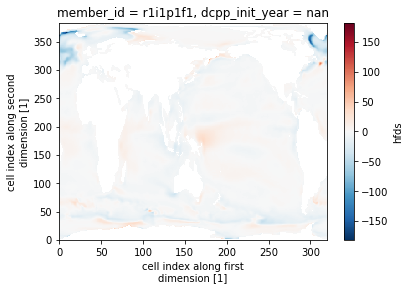

In [13]:
get_tcr('CMIP.SNU.SAM0-UNICON.piControl.Omon.gn', 'CMIP.SNU.SAM0-UNICON.1pctCO2.Omon.gn').hfds.plot()

In [14]:
ctrl_keys.pop(-3)
expr_keys.pop(-3)

'CMIP.SNU.SAM0-UNICON.1pctCO2.Omon.gn'

We will also remove AWI-CM because it raises a `MemoryError` that causes this notebook to fail to [execute via binderbot](https://github.com/ProjectPythia/cookbook-actions/blob/main/.github/workflows/build-book.yaml). Feel free to add it back if this notebook is being run locally.

In [15]:
ctrl_keys.pop(1)
expr_keys.pop(1)

'CMIP.AWI.AWI-CM-1-1-MR.1pctCO2.Omon.gn'

## Regrid the data

First, we will define the output grid. It does not matter what the data actually is, since we just want the structure of the Dataset.

In [16]:
rg_ds = rg_dset_dict['CMIP.NCAR.CESM2.piControl.Omon.gr'].isel(time=0).squeeze()
rg_ds

<xarray.Dataset>
Dimensions:         (lat: 180, lon: 360, d2: 2)
Coordinates:
  * lat             (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lat_bnds        (lat, d2) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon             (lon) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    lon_bnds        (lon, d2) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
    time            object 0001-01-15 13:00:00.999998
    time_bnds       (d2) object dask.array<chunksize=(2,), meta=np.ndarray>
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan
Dimensions without coordinates: d2
Data variables:
    hfds            (lat, lon) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
Attributes: (12/61)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            48545.0
    case_id:                          3
    ...                               ...
    intake_esm_attrs:variable_id:     hfds
    intake_esm_attrs:grid_label:      gr
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/NCAR/CESM2/piCont...
    intake_esm_attrs:version:         20190320
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCAR.CESM2.piControl.Omon.gr

Here we create a new dictionary to store our regridded data. The for-loop goes through the two sorted lists of keys and tries to regrid each model. This allows us to avoid removing a model and rerunning the code every time there is an error. 

To summarize,
- Get the diagnostic of interest and try to regrid to a 1x1 lat-lon grid
    - If that fails for any reason, print the error
    - If the regridding is successful, add it to the new dictionary
- Repeat for all models

In [17]:
ds_regrid_dict = dict()
success_count = 0
model_count = 0

for ctrl_key, expr_key in zip(ctrl_keys, expr_keys):
    model = ctrl_key.split('.')[2]
    try:
        ds_tcr = get_tcr(ctrl_key=ctrl_key, expr_key=expr_key)
        ds_tcr_hfds_regridded = regrid(ds_tcr, rg_ds, method='nearest_s2d').hfds
    except Exception as e:
        print('Failed to regrid '+model+': '+str(e))
    else: 
        ds_regrid_dict[model] = ds_tcr_hfds_regridded
        print(model+' regridded and added to dictionary')
        success_count += 1
    finally:
        model_count += 1
        
print('-'*40+'\n| '+str(success_count)+'/'+str(model_count)+' models successfully regridded! |\n'+'-'*40)

TaiESM1 regridded and added to dictionary


CAMS-CSM1-0 regridded and added to dictionary


FGOALS-g3 regridded and added to dictionary


CanESM5 regridded and added to dictionary


CMCC-CM2-SR5 regridded and added to dictionary


CMCC-ESM2 regridded and added to dictionary


ACCESS-CM2 regridded and added to dictionary


ACCESS-ESM1-5 regridded and added to dictionary


EC-Earth3-Veg regridded and added to dictionary


FIO-ESM-2-0 regridded and added to dictionary


IPSL-CM6A-LR regridded and added to dictionary


MPI-ESM1-2-HR regridded and added to dictionary


MPI-ESM1-2-LR regridded and added to dictionary


GISS-E2-1-G regridded and added to dictionary


GISS-E2-1-H regridded and added to dictionary


GISS-E2-2-G regridded and added to dictionary


Failed to regrid CESM2-FV2: lon and lat should be both 1D or 2D


CESM2-WACCM-FV2 regridded and added to dictionary


CESM2-WACCM regridded and added to dictionary


CESM2 regridded and added to dictionary


NorCPM1 regridded and added to dictionary


GFDL-CM4 regridded and added to dictionary


GFDL-ESM4 regridded and added to dictionary


NESM3 regridded and added to dictionary


CIESM regridded and added to dictionary


MCM-UA-1-0 regridded and added to dictionary
----------------------------------------
| 25/26 models successfully regridded! |
----------------------------------------


CESM2-FV2 fails because of some issue with the dimensions of the coordinates. If we remove `ignore_degenerate=True` from the regridder defined in `regrid()`, there may be a few more failures because of a degenerate element: a cell that has corners close enough that the cell collapses to a line or point.

Now we concat the results into a single DataArray:

In [18]:
ds = list(ds_regrid_dict.values())
coord = list(ds_regrid_dict.keys())
ds_out_regrid = xr.concat(objs=ds, dim=coord, coords='all').rename({'concat_dim':'model'})
ds_out_regrid

<xarray.DataArray 'hfds' (model: 25, lat: 180, lon: 360)>
dask.array<concatenate, shape=(25, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
    member_id       (model) <U8 'r1i1p1f1' 'r1i1p1f1' ... 'r1i1p1f1' 'r1i1p1f1'
    dcpp_init_year  (model) float64 nan nan nan nan nan ... nan nan nan nan nan
    time            (model) object 0001-01-15 13:00:00.999998 ... 0001-01-15 ...
  * lat             (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon             (lon) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * model           (model) object 'TaiESM1' 'CAMS-CSM1-0' ... 'MCM-UA-1-0'

## Plot or save the data

The following function extends `lon` by one grid point, giving it the value of the first point. This fixes a bug/feature of Cartopy where a vertical white line will appear at the "seam" of the plot. For example, if you have a dataset with longitudes [-179.5, 179.5] and make a plot centered on the Pacific, there will likely be a white line at 180. This is only for improving the look of the plot, so if you are doing further analysis or exporting to netCDF, skip this.

In [19]:
def add_cyclic_point(xarray_obj, dim, period=None):
    if period is None:
        period = xarray_obj.sizes[dim] / xarray_obj.coords[dim][:2].diff(dim).item()
    first_point = xarray_obj.isel({dim: slice(1)})
    first_point.coords[dim] = first_point.coords[dim]+period
    return xr.concat([xarray_obj, first_point], dim=dim)

Now we can take the ensemble mean and plot. Thanks to the work leading up to this point, it's as simple as using Xarray's `.mean()`.

In [20]:
cmip6em_ohutcr = add_cyclic_point(ds_out_regrid.mean(dim='model'), 'lon', period=360)
# cmip6em_ohutcr.to_netcdf('cmip6_ohutcr.nc') # remove add_cyclic_point() and uncomment to save
cmip6em_ohutcr

<xarray.DataArray 'hfds' (lat: 180, lon: 361)>
dask.array<concatenate, shape=(180, 361), dtype=float32, chunksize=(180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5 360.5

/srv/conda/envs/notebook/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


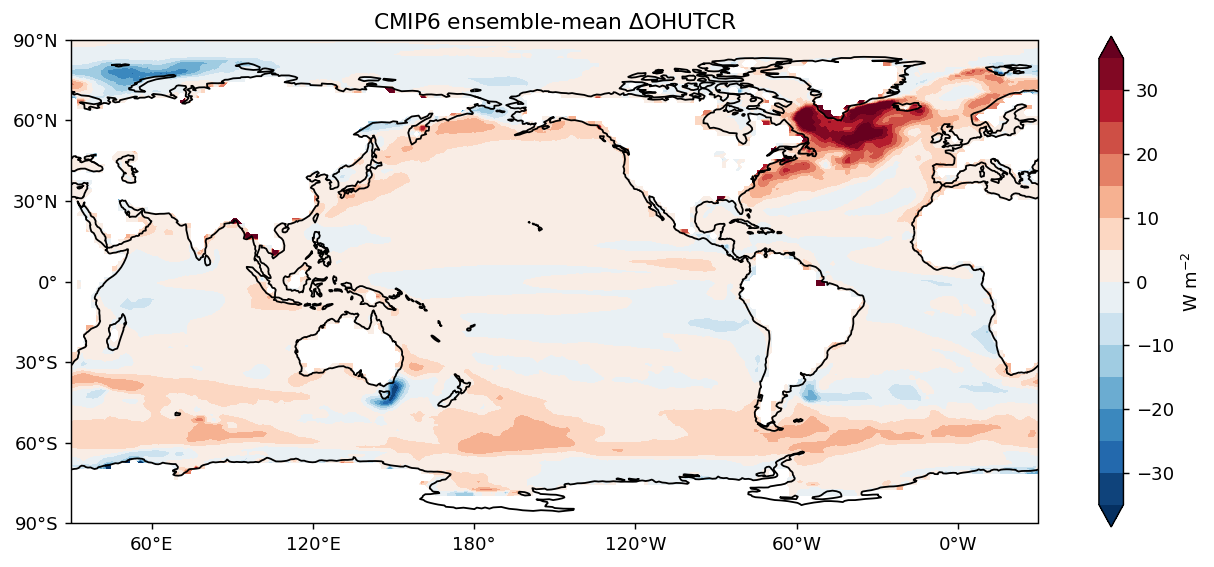

In [21]:
fig = plt.figure(1, figsize=(12, 5), dpi=130)
ax_mean = plt.subplot(projection=ccrs.PlateCarree(central_longitude=-150))
mean_plot = ax_mean.contourf(cmip6em_ohutcr.lon, cmip6em_ohutcr.lat, cmip6em_ohutcr, transform=ccrs.PlateCarree(), 
                             cmap='RdBu_r', levels=np.linspace(-35, 35, 15), extend='both')
ax_mean.set_title('CMIP6 ensemble-mean $\Delta\mathrm{OHUTCR}$')
ax_mean.coastlines()
ax_mean.set_xticks([-120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax_mean.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax_mean.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax_mean.yaxis.set_major_formatter(LatitudeFormatter())
plt.colorbar(mean_plot, orientation='vertical', label='W m$^{-2}$')

Notice how the heat uptake is highest in the subpolar oceans, especially the North Atlantic. From this multi-model ensemble mean, we can see that this is a robust feature of climate models (and likely the climate system itself) in response to a CO$_2$ forcing. For more background and motivation, see [Hu et al. (2020)](https://journals.ametsoc.org/view/journals/clim/33/17/jcliD190642.xml).

---

## Summary
This notebook demonstrates the use of xESMF to regrid the CMIP6 data hosted in Pangeo's Google cloud storage. The regridded data allows us to use Xarray to take a multi-model mean, in this case, of changes in ocean heat uptake associated with each model's transient climate response.

### What's next?
Other example workflows using this CMIP6 cloud data.

## Resources and references

Hu, S., Xie, S.-P., & Liu, W. (2020). Global Pattern Formation of Net Ocean Surface Heat Flux Response to Greenhouse Warming. Journal of Climate, 33(17), 7503–7522. [https://doi.org/10.1175/JCLI-D-19-0642.1](https://doi.org/10.1175/JCLI-D-19-0642.1)

Xie, S.-P. (2020). Ocean warming pattern effect on global and regional climate change. AGU Advances, 1, e2019AV000130. [https://doi.org/10.1029/2019AV000130](https://doi.org/10.1029/2019AV000130) 



Parts of this workflow were taken from a similar workflow in [this notebook by NordicESMhub](https://nordicesmhub.github.io/forces-2021/learning/example-notebooks/xesmf_regridding.html).